In [1]:
import array
import random
import json
import math

import numpy as np

from deap import algorithms
from deap import base
from deap import creator
from deap import tools

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

**Background**: The tsp is a np-hard problem which means it is not computationally  \
solvable  in  linear  time.  Instead,  the  computational  power  to  solve such \
a problem increases exponentially with the number of locations.

In [2]:
#@title Defining bounds for the Map
min_bounds = 0
max_bounds = 100
destinations = 22

random.seed(222)

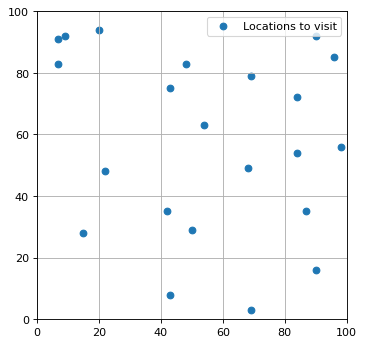

In [6]:
## plot random individuals on the map
figure(num=None, figsize=(5,5), dpi=80, facecolor='w', edgecolor='k')

map = np.random.randint(min_bounds, max_bounds, size=(destinations, 2))

plt.scatter(map[:,0], map[:,1], label="Locations to visit")
axes = plt.gca()
axes.set_ylim([min_bounds, max_bounds])
axes.set_xlim([min_bounds, max_bounds])
plt.legend()
plt.grid()

#plt.savefig('Initial_Problem', dpi=300, bbox_inches='tight')

In [7]:
## generate a path of the order of the visiting locations; First path simply is
# chronologically

def linear_path(map):
    path = []
    
    # enumerate points on the map 
    for i, _ in enumerate(map):
        path.append(i)
    
    return path

path = linear_path(map)

print('Current path: ')
path

Current path: 


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


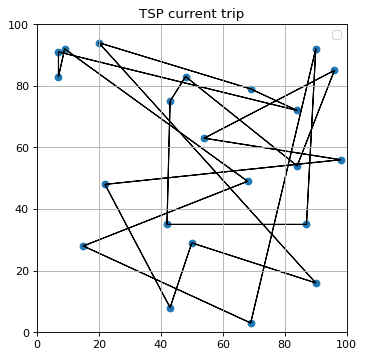

In [20]:
## draw path
def draw_path(path):
    
    # for saving
    from datetime import datetime 
    now = datetime.now()
    current_time = now.strftime("%H_%M_%S")
    
    
    
    figure(num=None, figsize=(5,5), dpi=80, facecolor='w', edgecolor='k')
    
    prev_pt = None
    
    plt.scatter(map[:,0], map[:,1])
    
    for i in path:
        pt = map[i]
        
        if prev_pt is not None:
            plt.arrow(pt[0], pt[1], prev_pt[0]- pt[0], prev_pt[1]- pt[1])
            
        else:
            start_pt = pt
            
        prev_pt = pt
    
    # go back to starting destination to fullfill the round trip
    plt.arrow(pt[0],pt[1], start_pt[0]-pt[0], start_pt[1]-pt[1])
    
    # NOTE: plt.arrow works by defining the starting point in x,y coordinates. 
    # Hereafter the change in the coordinates is defined (dx, dy)
    # => plt.arrow(x, y, dx, dy)
    
    axes = plt.gca()
    axes.set_xlim([min_bounds,max_bounds])
    axes.set_ylim([min_bounds,max_bounds])
    plt.title('TSP current trip')
    #plt.title('Initial random solution')
    plt.grid()
    #plt.legend()
    
    plt.savefig(f'Solution_step_{current_time}', dpi=300, bbox_inches='tight')
    plt.show()
    
    
    
draw_path(path)

In [21]:
## evaluate the fitness of the current path (= global path length)

def evaluate_path(path):
    prev_pt = None
    
    distance = 0 
    
    for i in path:
        pt = map[i]
        
        if prev_pt is not None:
            distance += math.sqrt((prev_pt[0] - pt[0]) ** 2 + (prev_pt[1] - pt[1]) ** 2)
            
        else:
            start_pt = pt
        
        prev_pt = pt
        
    distance += math.sqrt((start_pt[0] - pt[0]) ** 2 + (start_pt[1] - pt[1]) ** 2)
    
    # returns distance as set
    return distance, 


evaluate_path(path)

(1058.8507690962638,)

In [22]:
## the creator
creator.create('FitnessMin', base.Fitness, weights=(-1.0,))
creator.create('Individual', array.array,  typecode='i', fitness=creator.FitnessMin)

c:\Users\pnmue\anaconda3\envs\evol_DL\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\pnmue\anaconda3\envs\evol_DL\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [23]:
## the toolbox

toolbox = base.Toolbox()

# generate a gene type called indices of the lenght of destinations; destination = fixed to 22
toolbox.register('indices', random.sample, range(destinations), destinations)
    # NOTE: eg. random.sample(range(22), 22) -> [3, 7, 9, 19, 1, 0, 15, 21, 20, 11, 12, 13, 10, 17, 16, 18, 14, 6, 5, 2, 4, 8]

# create an individual using the indices gene type
toolbox.register('individual', tools.initIterate, creator.Individual, toolbox.indices)

# create the population list to hold the individuals
toolbox.register('population', tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxPartialyMatched)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate_path)

```mermaid
flowchart TD
    A[Generate GeneType]-->|Gene Type| B[Use GeneType]
    B --> |Individuals| C[Use individuals] 
    C --> D[Population]
    
    
    style A fill:#1f77b4
    style B fill:#1f77b4
    style C fill:#1f77b4
    style D fill:#1f77b4

```

In [24]:
## evolution function

def eaSimple(population, toolbox, cxpb, mutpb, ngen, stats=None, halloffame=None):  
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)    
    print(logbook.stream)
    done = False

    # Begin the generational process
    for gen in range(1, ngen + 1):
        if done: return
        # Select the next generation individuals
        offspring = toolbox.select(population, len(population))

        offspring = [toolbox.clone(ind) for ind in offspring]

        # Apply crossover and mutation on the offspring
        for i in range(1, len(offspring), 2):
            if random.random() < cxpb:
                offspring[i - 1], offspring[i] = toolbox.mate(offspring[i - 1],
                                                              offspring[i])
                del offspring[i - 1].fitness.values, offspring[i].fitness.values

        for i in range(len(offspring)):
            if random.random() < mutpb:
                offspring[i], = toolbox.mutate(offspring[i])
                del offspring[i].fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit  

        # Update the hall of fame with the generated individuals
        if halloffame is not None:
            halloffame.update(offspring)             
            draw_path(halloffame[0])           

        # Replace the current population by the offspring
        population[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        print(logbook.stream)    

**Important**

If the connected points don't form a loop, the solution is not valid to the \
problem

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


gen	nevals	avg    	std    	min    	max    
0  	300   	1211.14	96.8087	948.536	1409.63


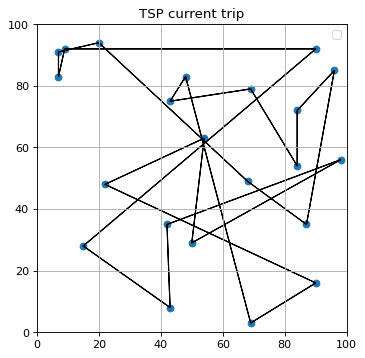

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1  	229   	1166   	106.615	879.388	1419.89


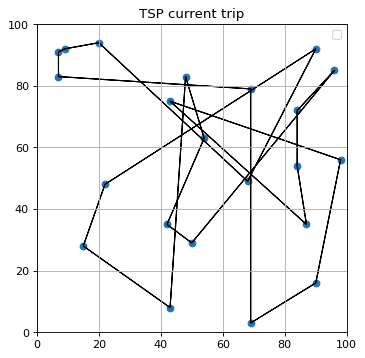

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2  	235   	1123.11	101.955	857.286	1393.72


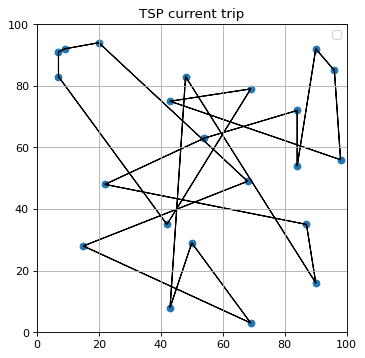

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


3  	243   	1115.04	102.705	854.776	1423.49


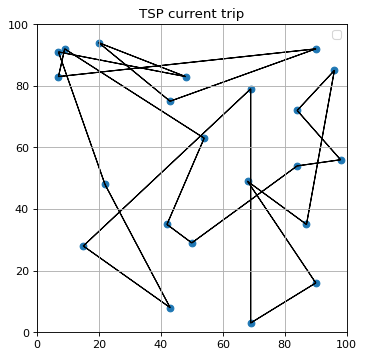

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


4  	237   	1102.6 	113.478	847.838	1413.46


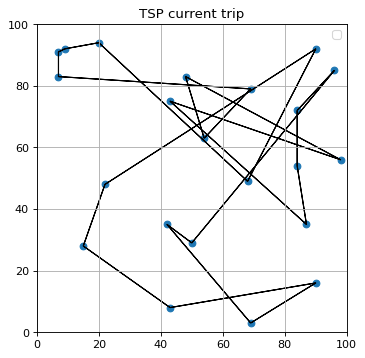

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


5  	239   	1073.28	111.662	803.165	1451.36


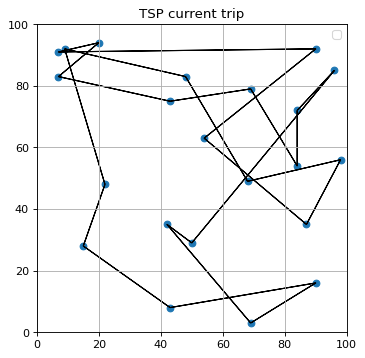

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


6  	233   	1058.18	120.58 	763.09 	1459.49


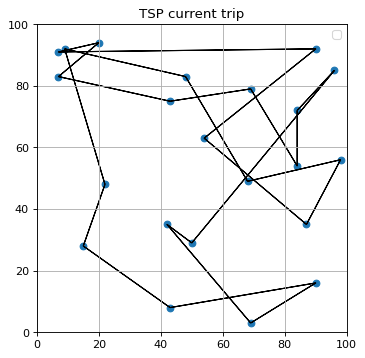

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


7  	234   	1040.7 	117.979	763.09 	1410.42


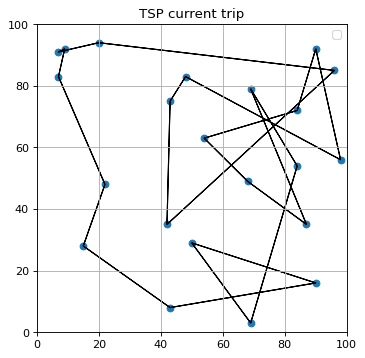

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


8  	227   	1036.18	125.556	759.142	1418.09


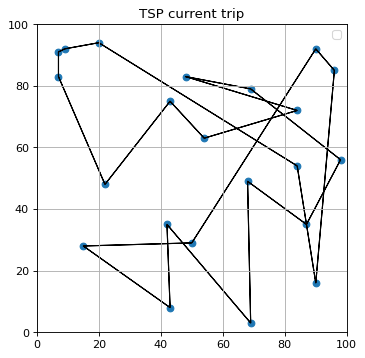

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


9  	232   	1027.13	122.885	736.012	1432.41


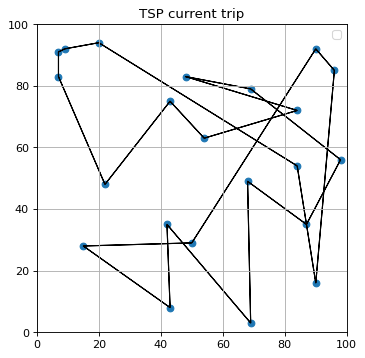

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


10 	210   	1013.98	124.586	736.682	1419.25


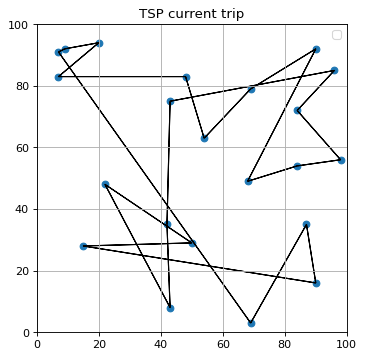

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


11 	248   	1013   	128.27 	731.662	1411.78


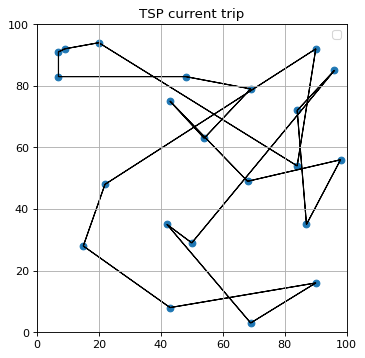

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


12 	245   	1012.23	141.072	714.649	1391.73


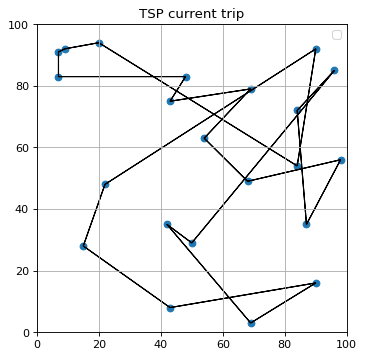

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


13 	261   	985.555	137.667	696.462	1439.23


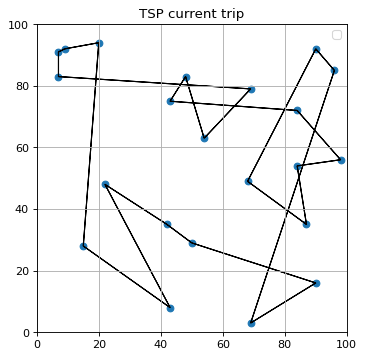

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


14 	249   	965.573	131.771	645.379	1337.85


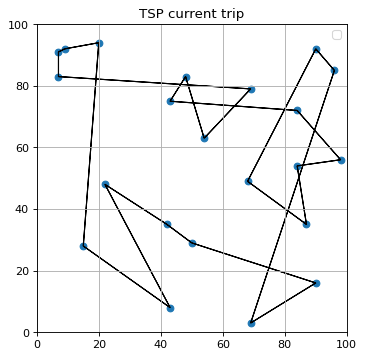

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


15 	245   	957.237	130.519	645.379	1388.74


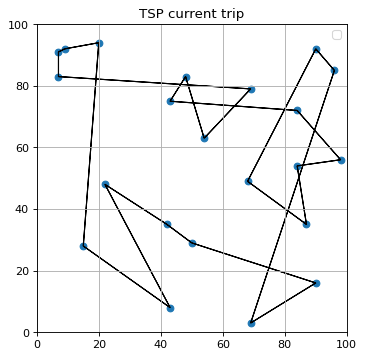

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


16 	233   	912.165	121.564	645.379	1316.5 


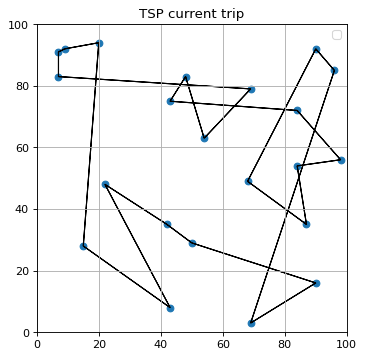

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


17 	243   	923.44 	128.785	645.379	1314.69


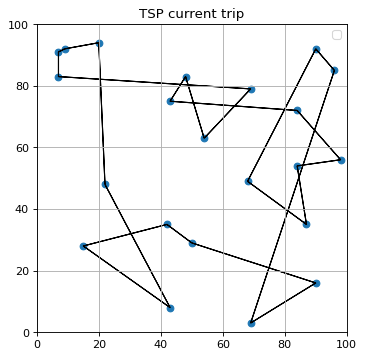

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


18 	230   	922.524	131.565	629.272	1315.71


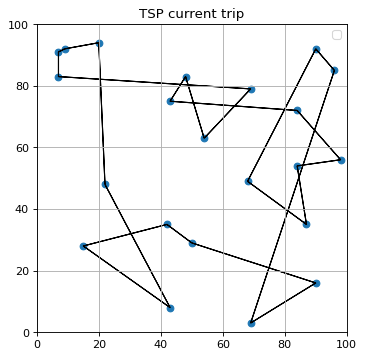

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


19 	222   	892.563	114.162	629.272	1251.21


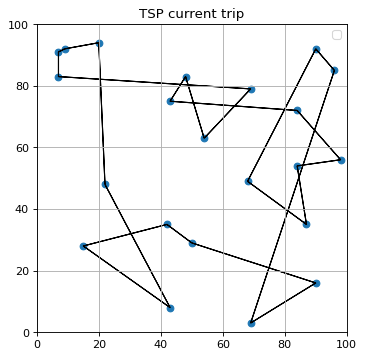

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


20 	244   	876.496	117.868	629.272	1250.11


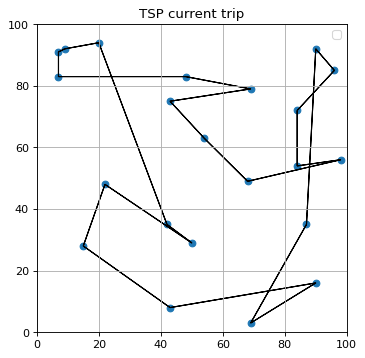

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


21 	244   	853.448	113.087	564.61 	1226.34


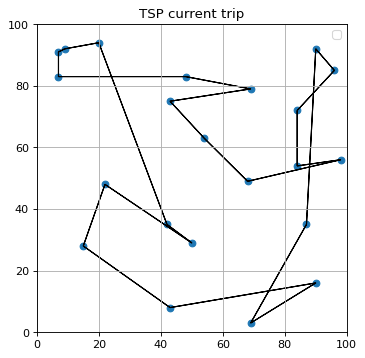

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


22 	247   	841.739	126.107	572.012	1335.82


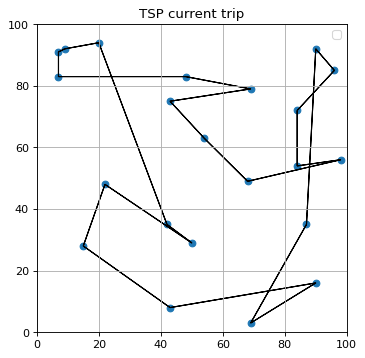

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


23 	222   	804.538	112.631	572.012	1208.48


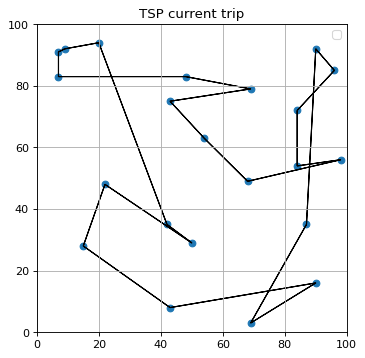

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


24 	233   	782.593	122.467	572.012	1245.54


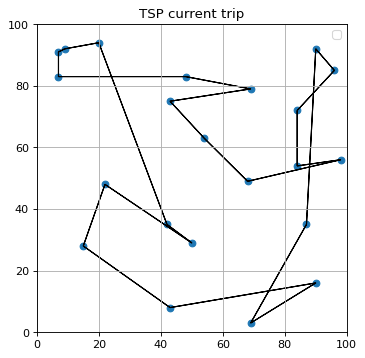

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


25 	236   	750.367	112.465	572.012	1178.11


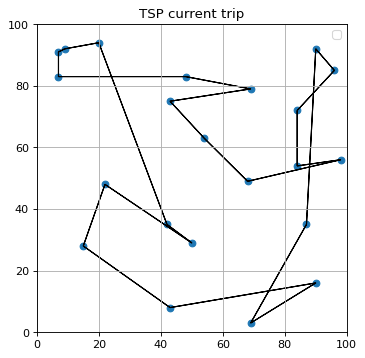

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


26 	228   	701.946	101.602	572.012	1164.02


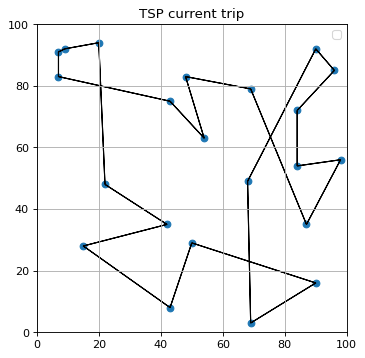

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


27 	255   	683.46 	106.688	562.536	1094.18


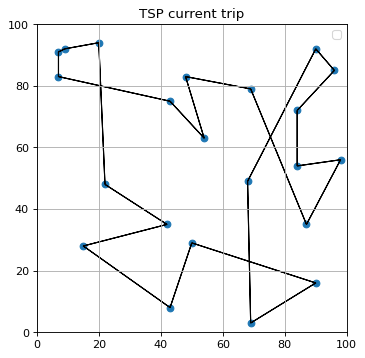

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


28 	242   	663.766	100.749	562.536	1112.63


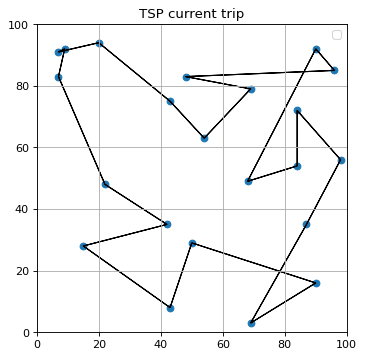

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


29 	240   	650.214	94.9811	549.354	1138.61


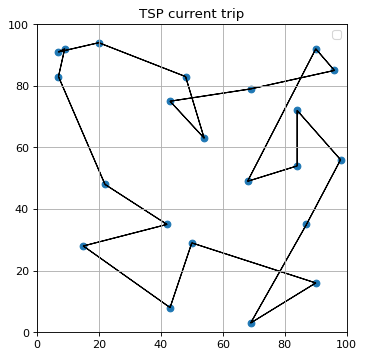

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


30 	247   	629.493	83.3303	533.098	1139.02


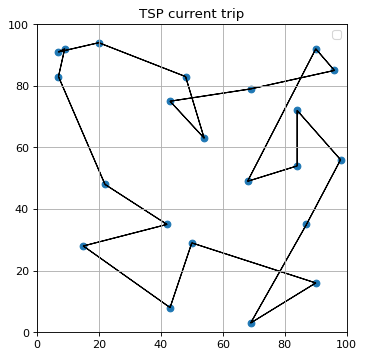

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


31 	238   	617.558	82.3355	544.934	1264.71


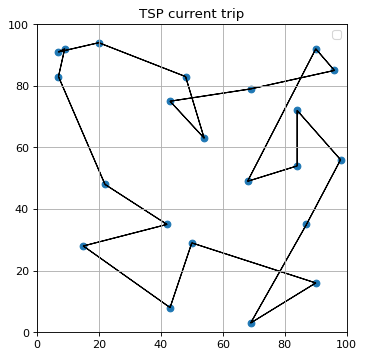

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


32 	242   	623.389	100.378	544.824	1231.54


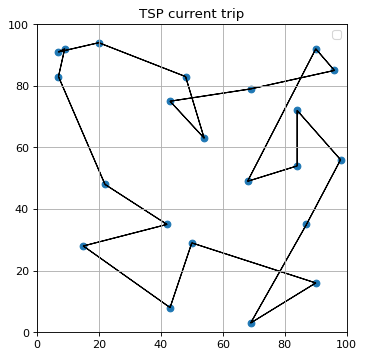

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


33 	215   	604.633	79.44  	535.583	973.857


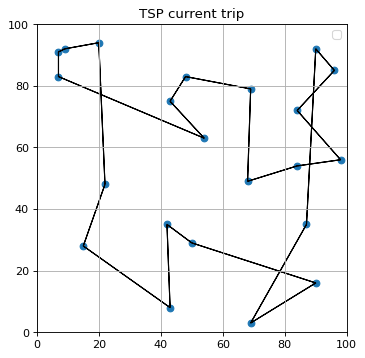

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


34 	237   	608.901	99.1941	527.891	1055.99


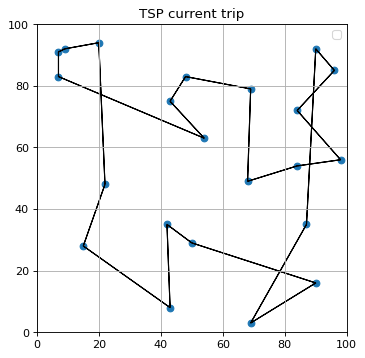

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


35 	230   	596.638	86.7598	527.891	1022.23


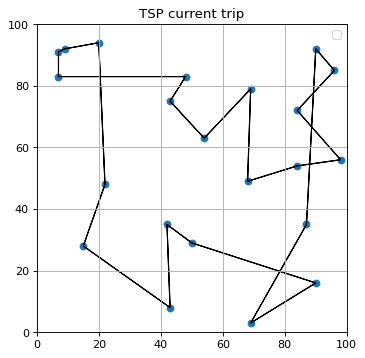

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


36 	242   	597.503	94.7726	518.367	1067.96


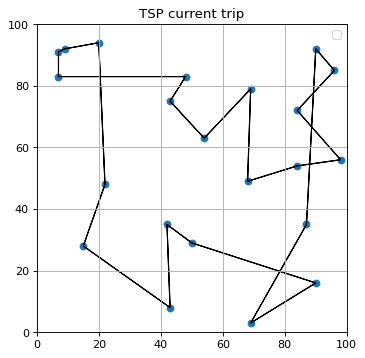

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


37 	233   	592.876	96.2065	518.367	1011.93


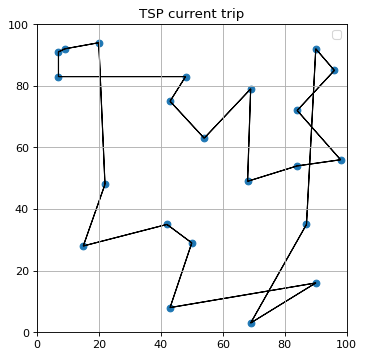

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


38 	222   	577.767	90.6222	512.584	1165.5 


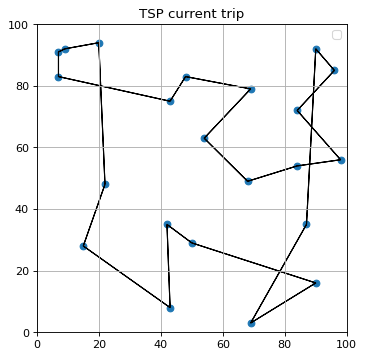

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


39 	254   	563.157	67.9069	509.126	956.077


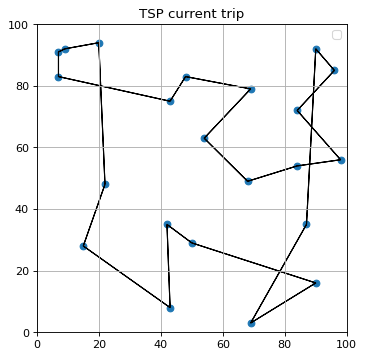

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


40 	253   	568.723	86.427 	513.649	979.255


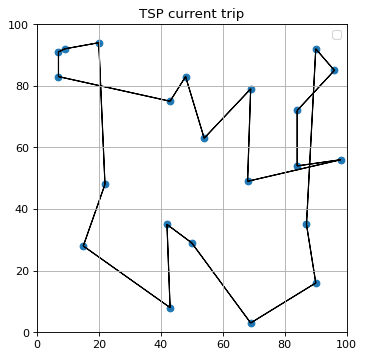

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


41 	228   	563.116	88.6273	502.293	963.337


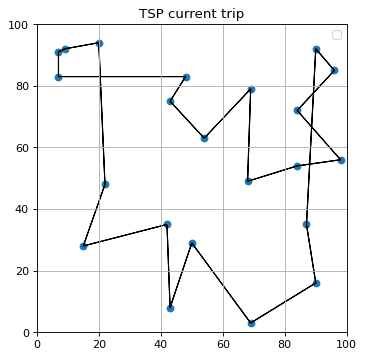

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


42 	250   	561.812	90.4925	496.65 	1055.82


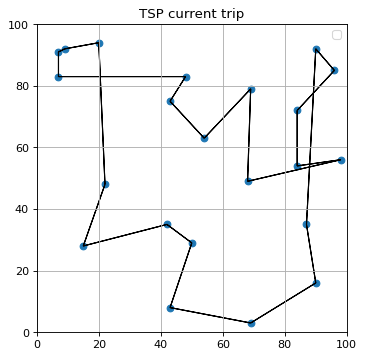

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


43 	240   	556.624	98.896 	484.687	1118.64


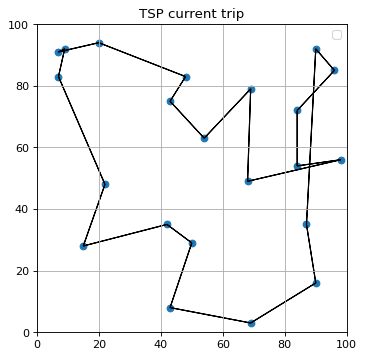

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


44 	250   	562.517	96.7731	469.187	971.989


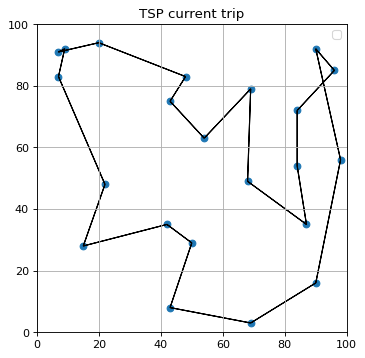

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


45 	242   	553.252	94.6387	468.431	1003.82


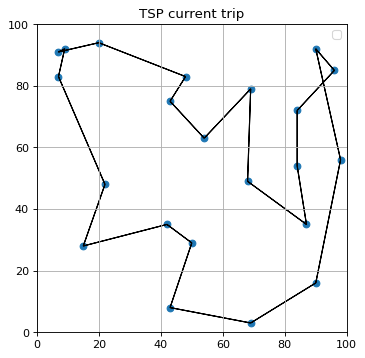

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


46 	232   	545.12 	93.8027	468.431	978.44 


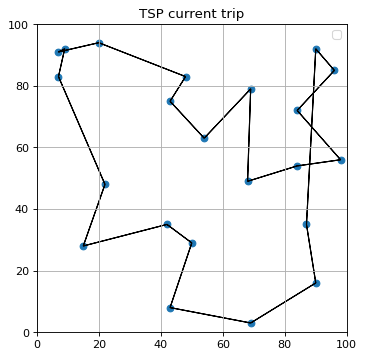

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


47 	242   	538.132	101.395	458.404	1009.08


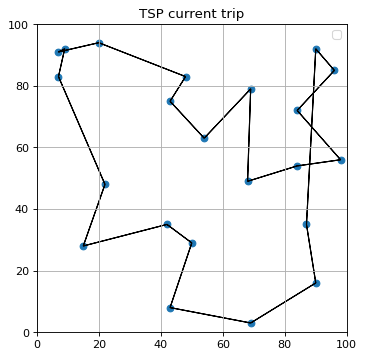

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


48 	242   	524.92 	100.107	463.075	1041.46


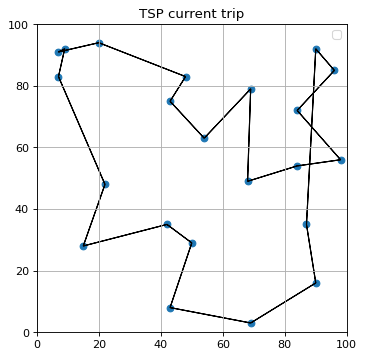

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


49 	226   	517.54 	103.611	458.404	1136.02


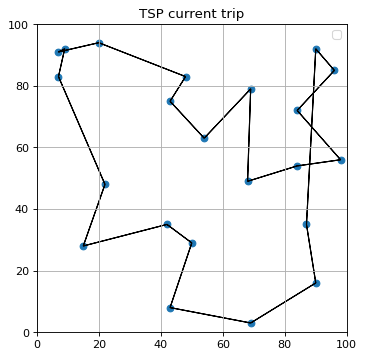

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


50 	250   	515.704	95.5978	458.404	1016.38


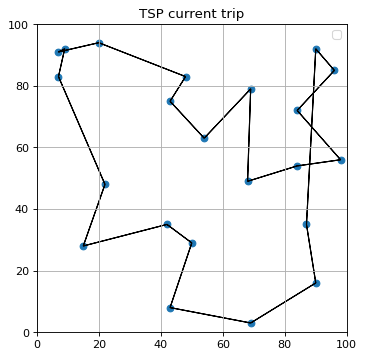

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


51 	229   	511.168	99.8948	458.404	1018.44


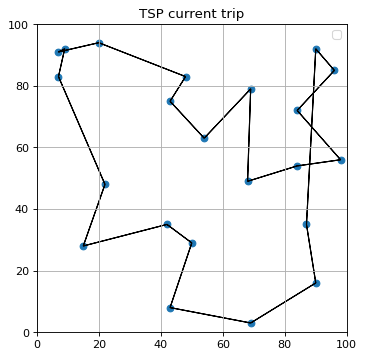

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


52 	231   	510.97 	95.699 	458.404	894.024


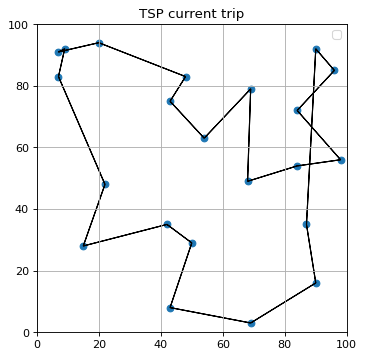

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


53 	247   	513.255	96.0646	458.404	947.752


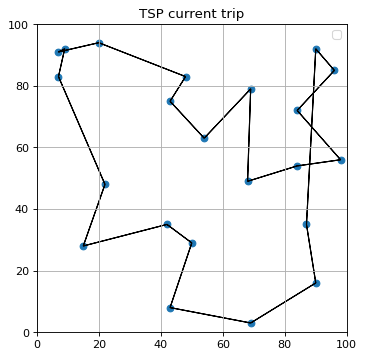

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


54 	228   	516.897	112.938	458.404	962.753


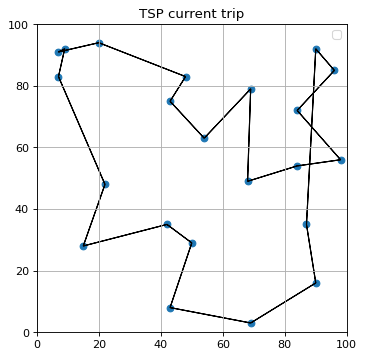

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


55 	210   	506.216	109.2  	458.404	1085.43


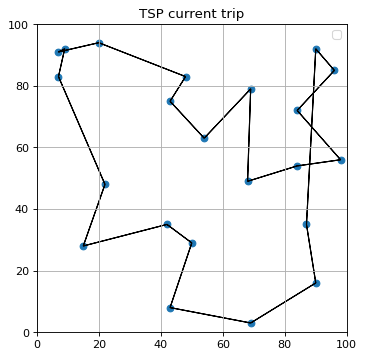

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


56 	237   	500.088	99.0173	458.404	1066.31


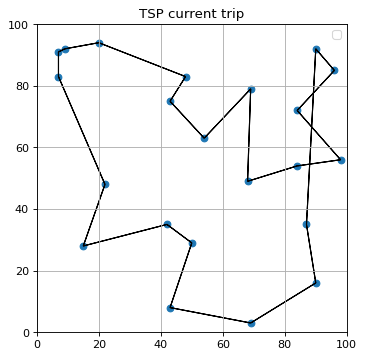

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


57 	248   	509.683	120.548	455.024	1175.71


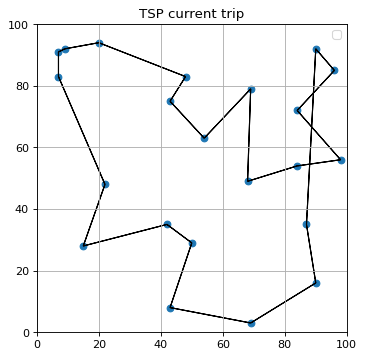

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


58 	229   	493.758	96.5288	455.024	1146.1 


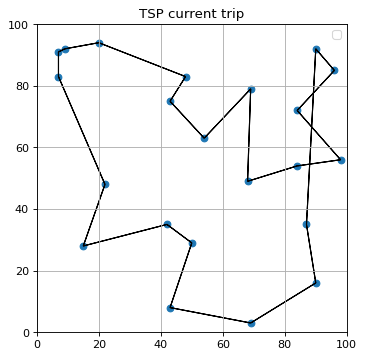

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


59 	224   	502.684	105.619	455.024	1012.16


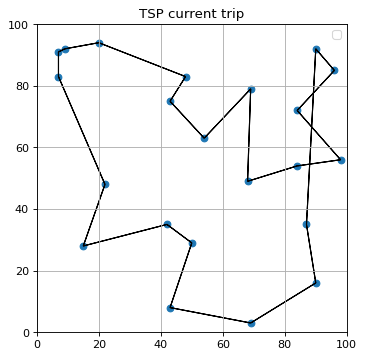

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


60 	232   	508.068	119.402	455.024	1159.78


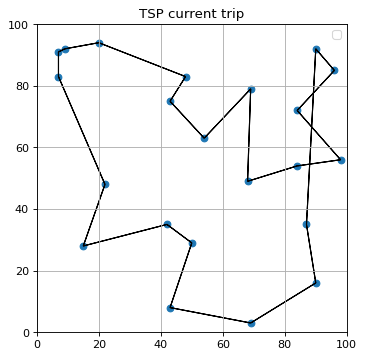

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


61 	225   	506.708	110.862	455.024	1066.59


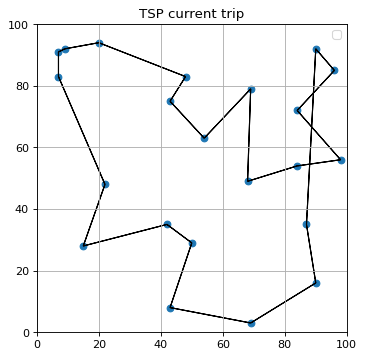

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


62 	244   	503.796	113.397	455.024	1031.16


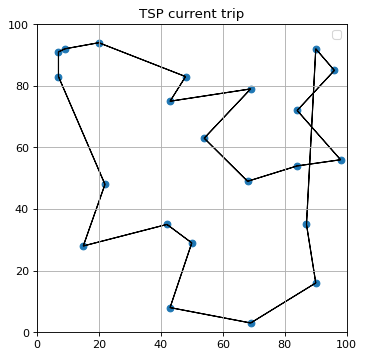

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


63 	241   	497.657	100.11 	454.833	972.375


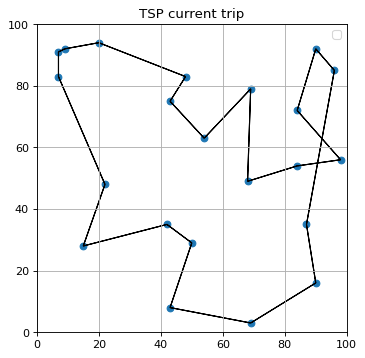

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


64 	232   	499.205	108.343	451.937	1068.61


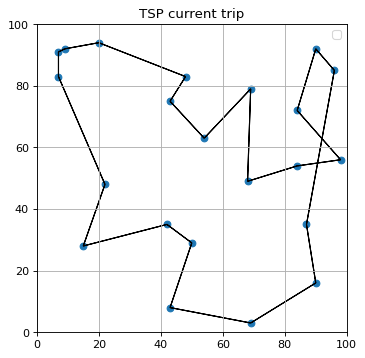

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


65 	240   	491.679	96.2129	451.937	963.692


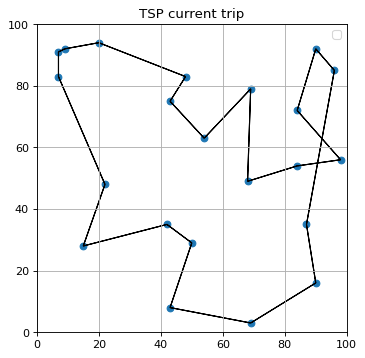

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


66 	248   	488.147	89.2862	451.937	907.025


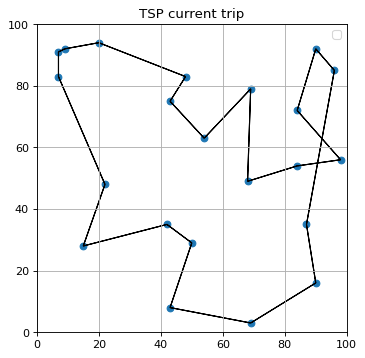

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


67 	246   	501.301	105.94 	451.937	984.301


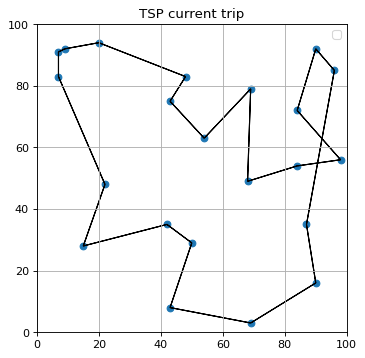

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


68 	234   	493.256	89.2711	451.937	965.817


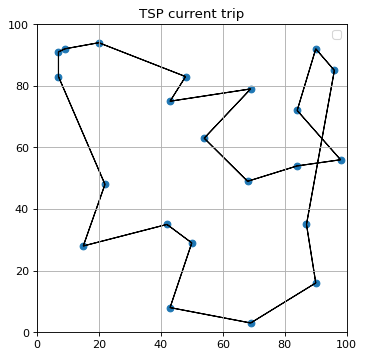

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


69 	241   	500.414	108.278	451.746	994.24 


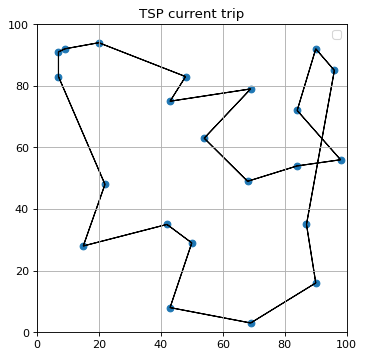

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


70 	242   	507.04 	114.796	451.746	1048.53


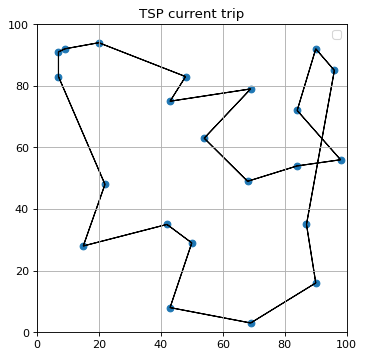

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


71 	237   	496.344	101.543	451.746	1020.55


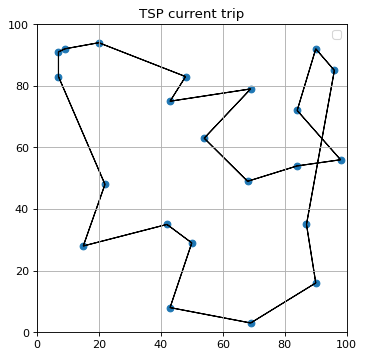

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


72 	229   	490.575	105.518	451.746	1065.35


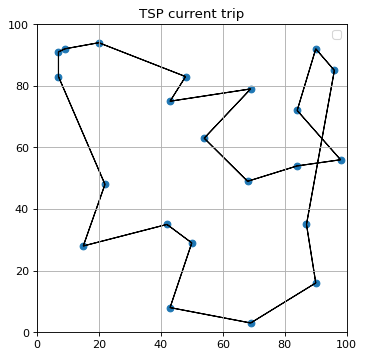

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


73 	234   	490.876	93.8595	451.746	1012.61


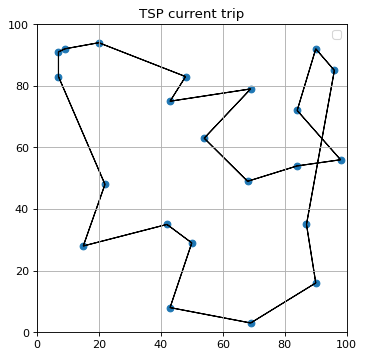

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


74 	233   	493.555	103.747	451.746	990.839


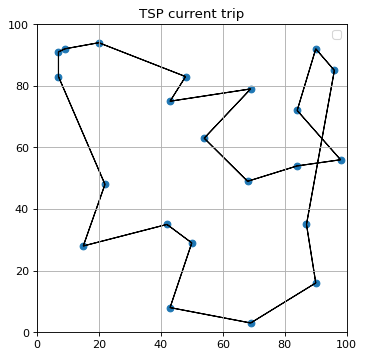

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


75 	233   	487.856	85.8085	451.746	1009.18


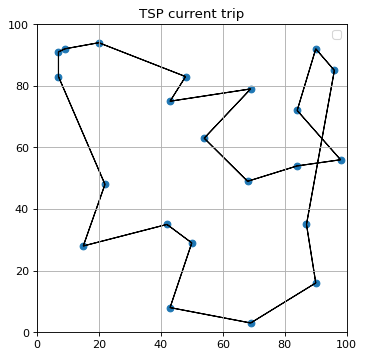

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


76 	226   	488.933	104.522	451.746	1032.81


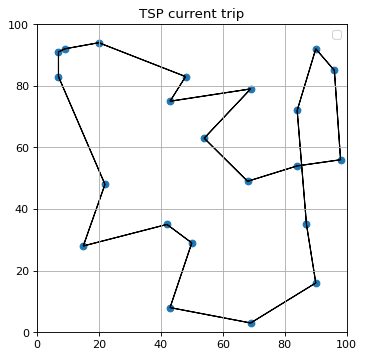

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


77 	230   	484.502	87.8504	445.873	941.677


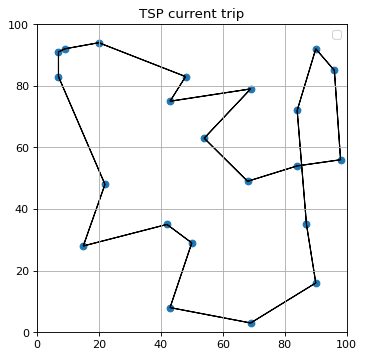

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


78 	235   	494.9  	105.789	445.873	1050.5 


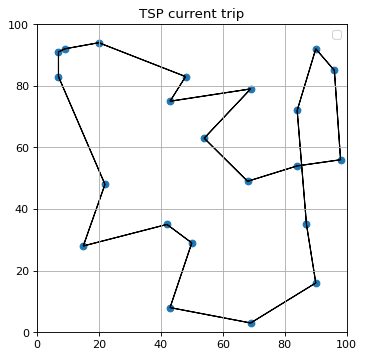

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


79 	230   	495.002	102.079	445.873	1007.02


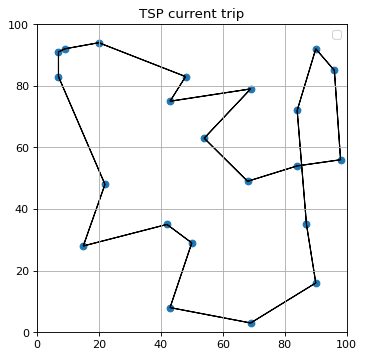

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


80 	243   	508.303	114.493	445.873	1114.82


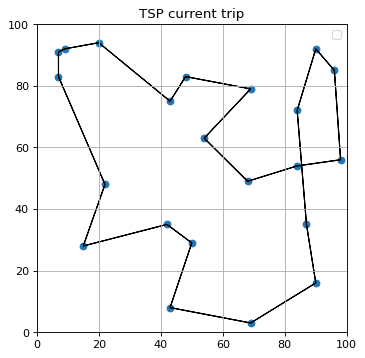

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


81 	235   	483.267	88.5937	440.694	1049.25


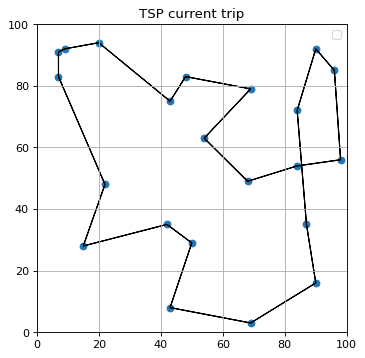

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


82 	253   	483.053	84.616 	440.694	959.81 


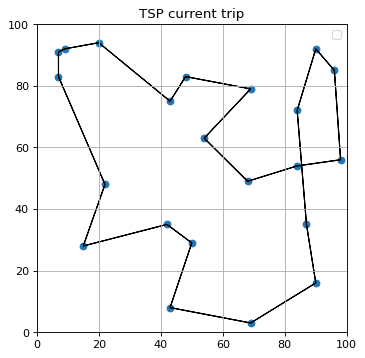

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


83 	246   	482.376	94.446 	440.694	926.099


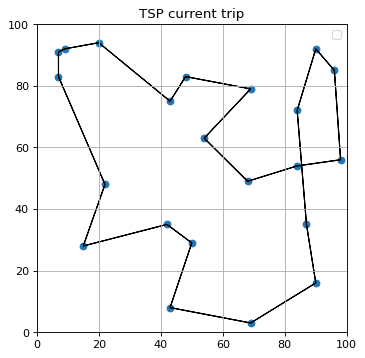

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


84 	246   	482.584	94.6357	440.694	956.267


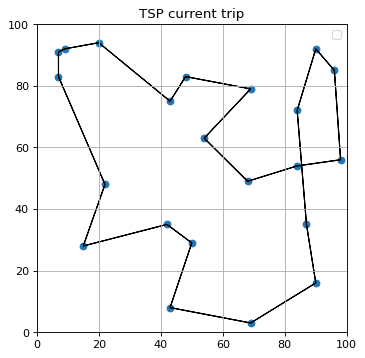

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


85 	209   	487.259	109.567	440.694	1172.45


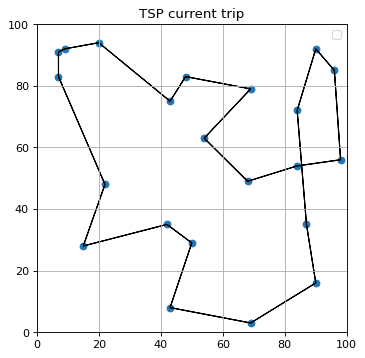

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


86 	243   	478.355	89.6488	440.694	897.251


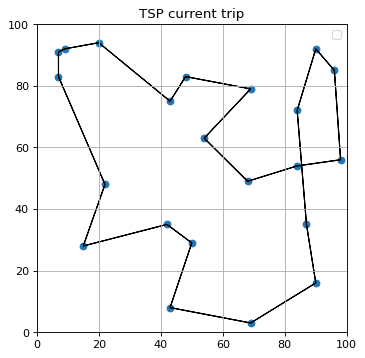

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


87 	235   	483.691	106.732	440.694	1180.28


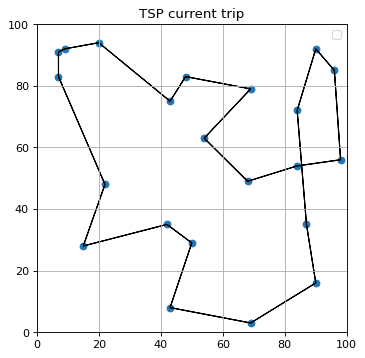

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


88 	238   	474.215	87.2288	440.694	907.932


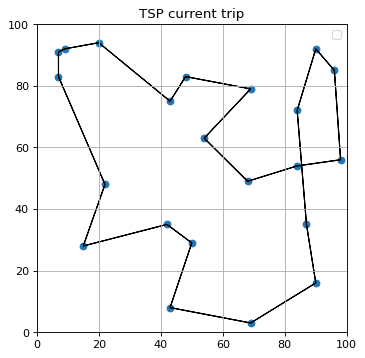

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


89 	232   	493.776	121.816	440.694	1219.01


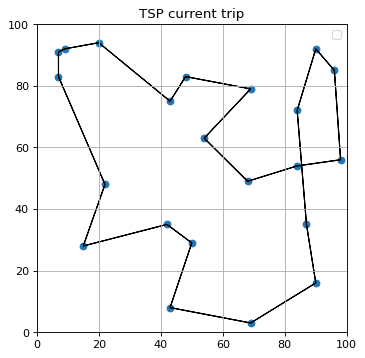

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


90 	232   	475.524	87.3295	440.694	914.584


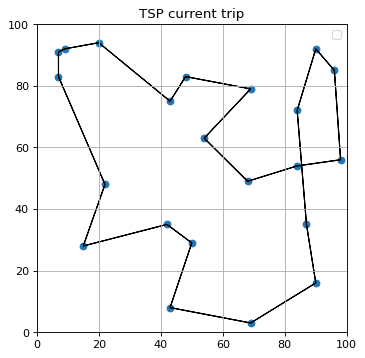

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


91 	236   	482.08 	103.363	440.694	954.76 


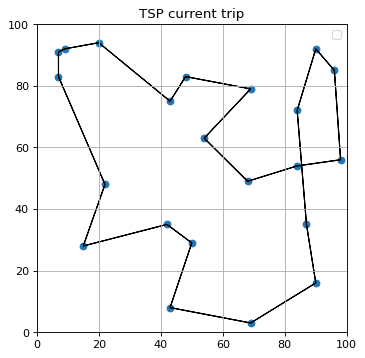

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


92 	232   	485.195	98.5646	440.694	927.761


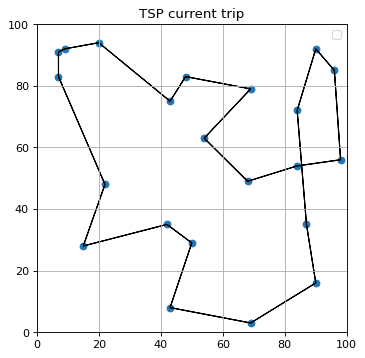

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


93 	228   	480.123	100.428	440.694	1073.04


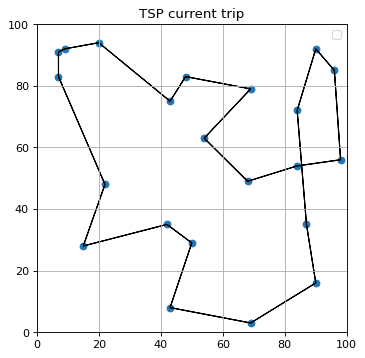

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


94 	240   	476.847	90.8979	440.694	907.976


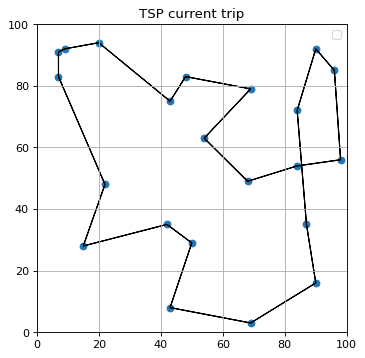

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


95 	238   	485.869	111.206	440.694	1026.78


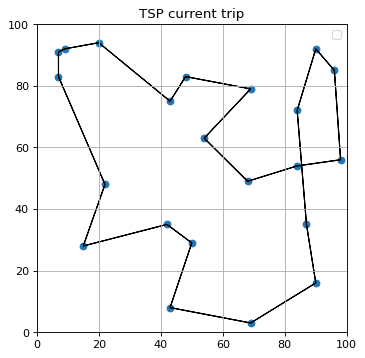

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


96 	235   	478.922	102.76 	440.694	1132.48


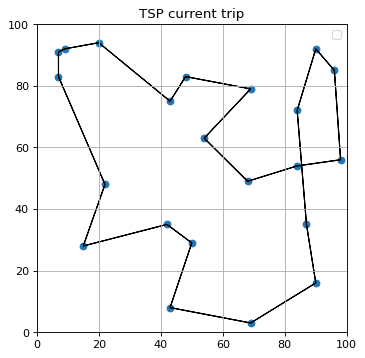

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


97 	233   	481.557	100.702	440.694	1001.52


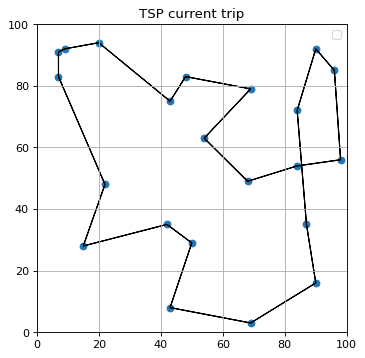

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


98 	232   	479.148	95.2186	440.694	928.709


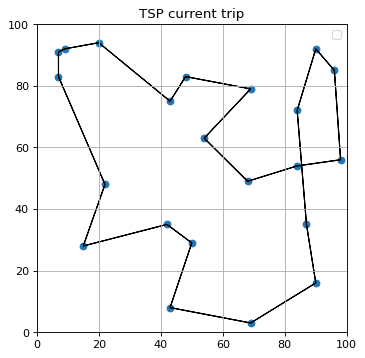

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


99 	226   	481.933	98.375 	440.694	952.898


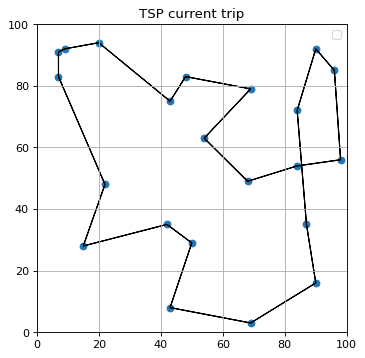

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


100	222   	483.745	101.78 	440.694	974.747


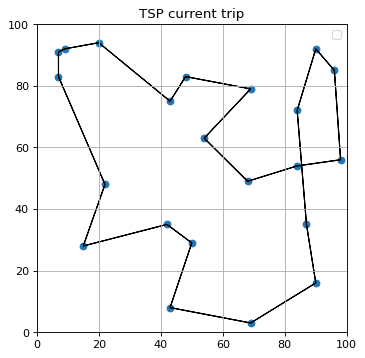

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


101	250   	486.599	106.486	440.694	1004.86


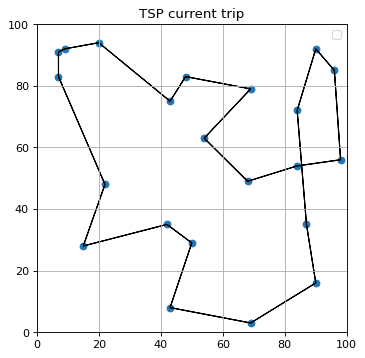

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


102	243   	490.355	116.988	440.694	1144.67


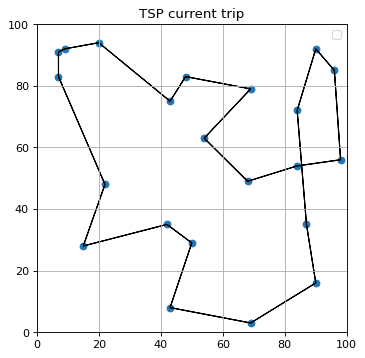

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


103	247   	490.012	110.782	440.694	979.797


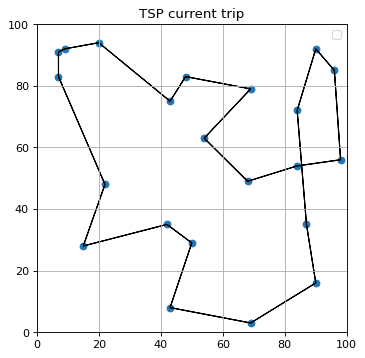

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


104	214   	476.781	94.8336	440.694	1084.4 


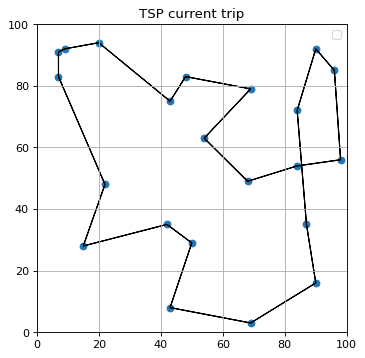

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


105	235   	486.113	101.943	440.694	934.157


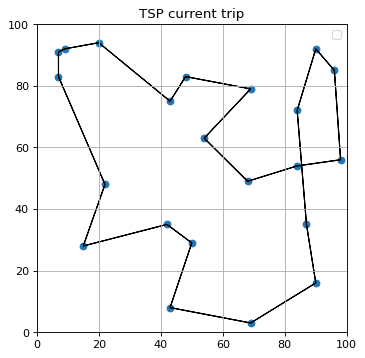

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


106	240   	484.461	102.542	440.694	956.528


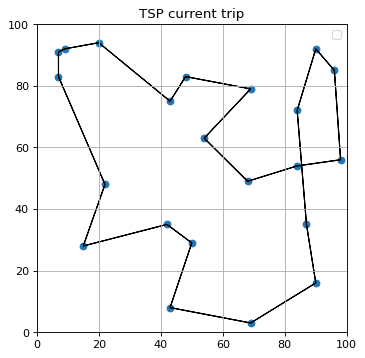

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


107	239   	475.885	92.1543	440.694	931.83 


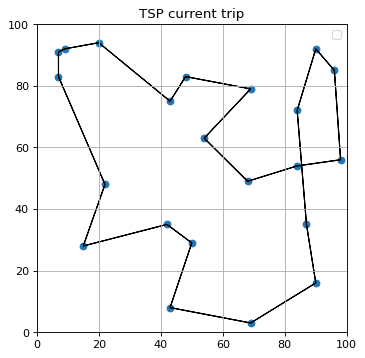

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


108	241   	505.261	132.052	440.694	1050.72


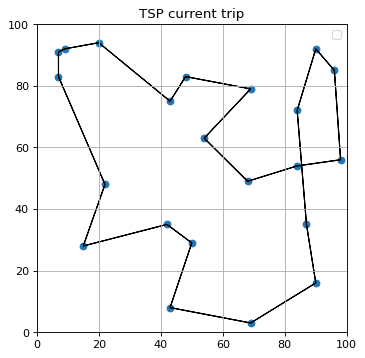

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


109	243   	484.218	97.7905	440.694	971.886


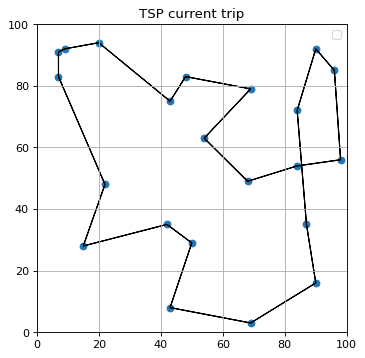

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


110	228   	481.595	106.227	440.694	1263.76


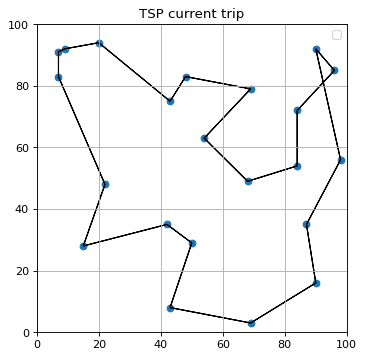

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


111	239   	480.553	102.515	435.758	1036.58


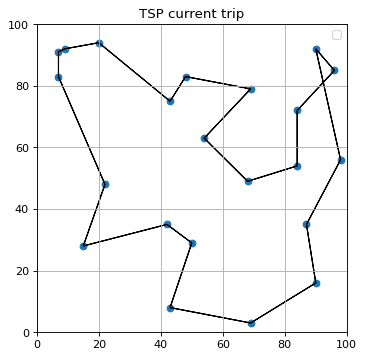

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


112	247   	500.787	130.578	435.758	1119   


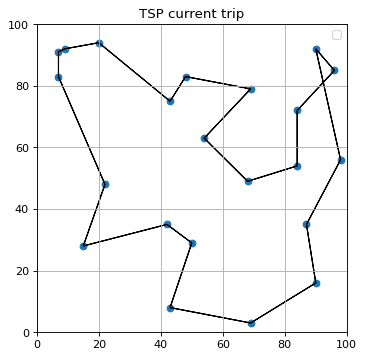

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


113	236   	481.967	108.7  	435.758	1109.71


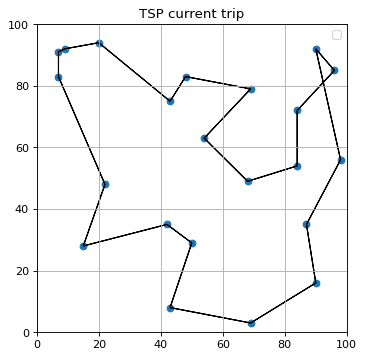

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


114	254   	489.261	112.17 	435.758	1117.63


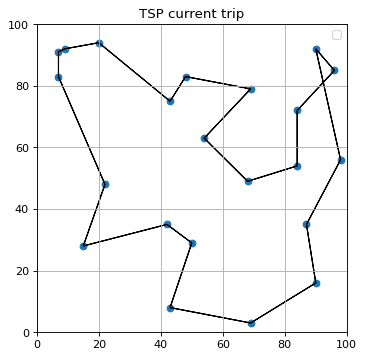

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


115	232   	480.46 	99.6732	435.758	986.974


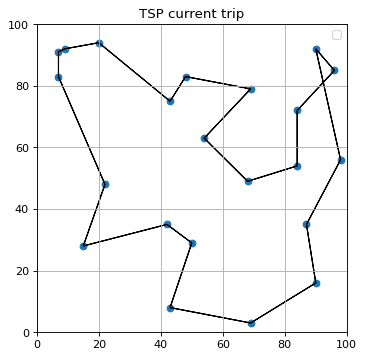

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


116	234   	478.834	95.4851	435.758	927.914


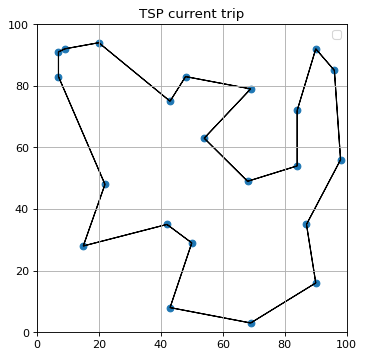

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


117	236   	494.961	126.986	431.137	1048.54


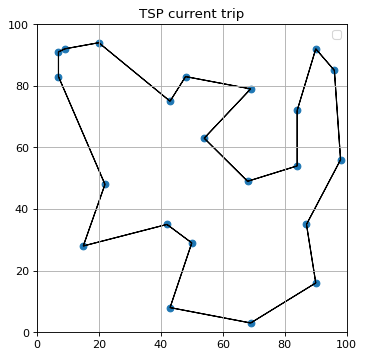

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


118	235   	482.42 	103.907	431.137	1135.14


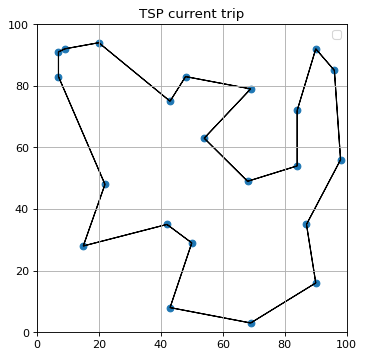

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


119	226   	475.008	94.418 	431.137	1047.82


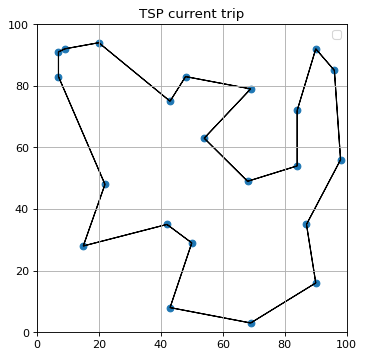

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


120	235   	484.793	109.956	431.137	1050.85


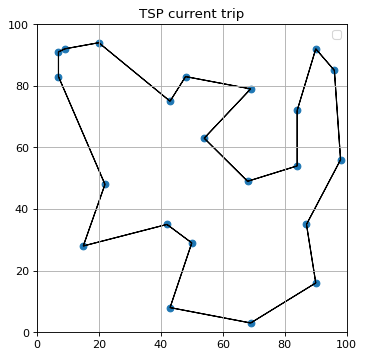

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


121	248   	473.631	93.5653	431.137	903.411


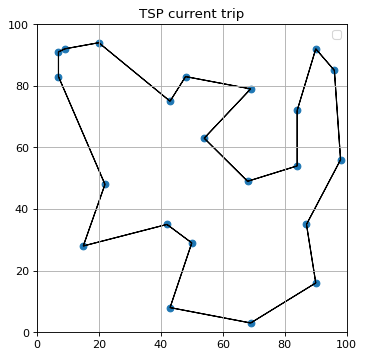

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


122	236   	490.862	122.293	431.137	1095.07


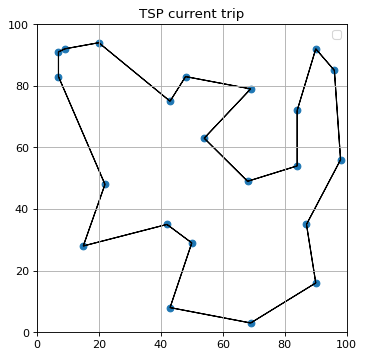

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


123	254   	475.709	97.7792	431.137	938.303


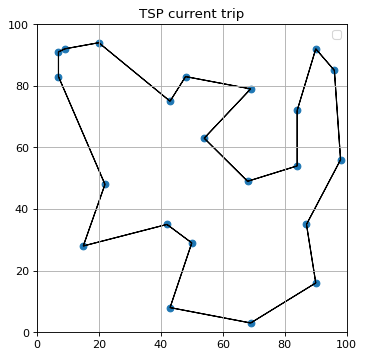

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


124	240   	479.605	112.587	431.137	1099.2 


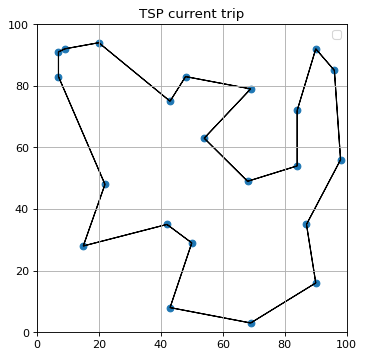

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


125	246   	473.976	97.5517	431.137	942.701


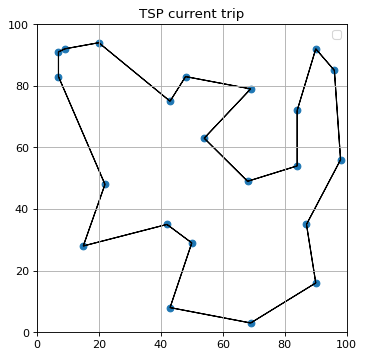

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


126	239   	473.344	97.0363	431.137	898.733


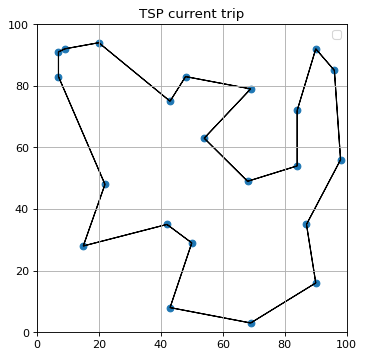

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


127	239   	474.58 	100.131	431.137	955.949


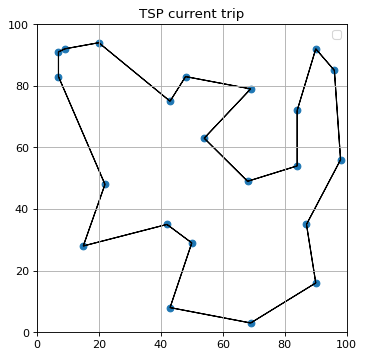

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


128	236   	474.381	103.338	431.137	1122.45


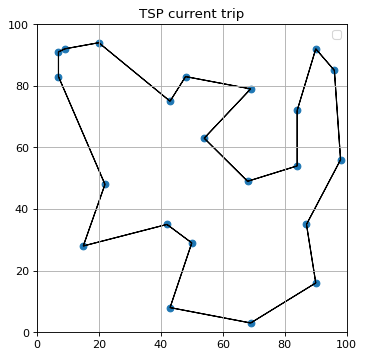

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


129	240   	470.903	99.6469	431.137	990.928


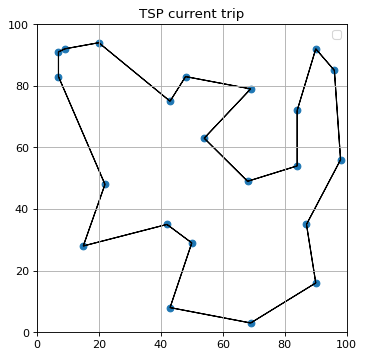

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


130	251   	476.979	102.168	431.137	1036.82


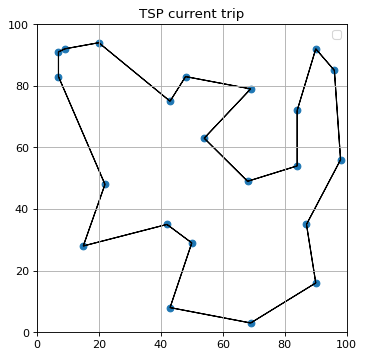

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


131	238   	478.496	110.588	431.137	948.68 


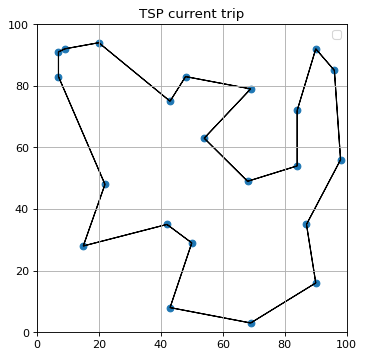

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


132	236   	471.789	103.25 	431.137	1032.29


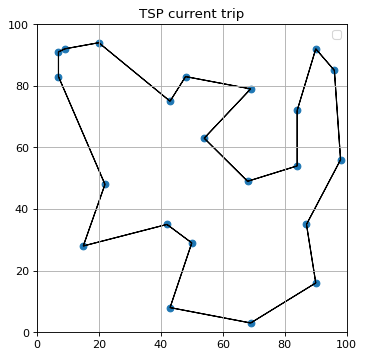

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


133	241   	472.632	107.472	431.137	1036.73


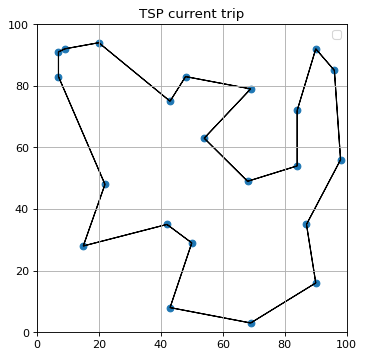

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


134	248   	475.697	104.75 	431.137	982.923


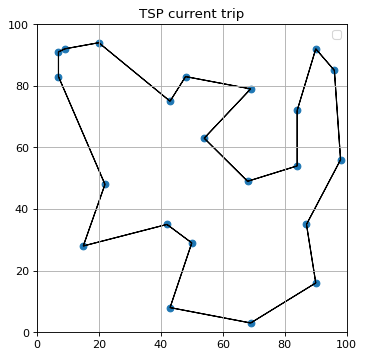

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


135	230   	470.652	101.017	431.137	1086.45


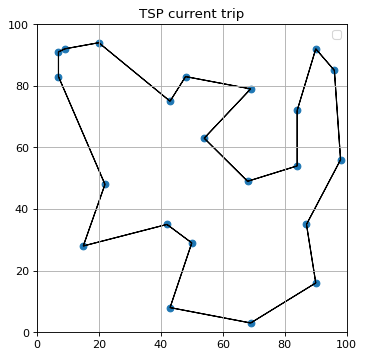

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


136	229   	464.919	85.2178	431.137	950.944


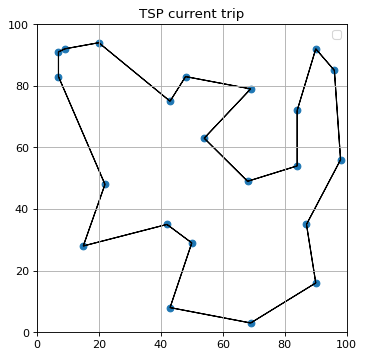

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


137	246   	476.367	105.622	431.137	1057.53


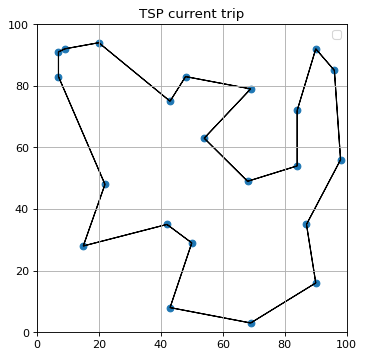

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


138	231   	481.721	113.414	431.137	1035.24


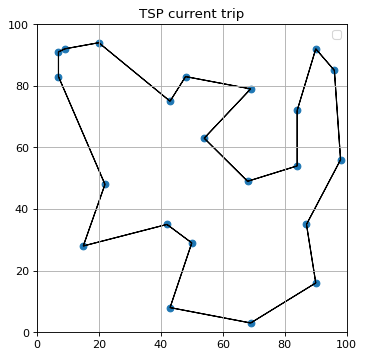

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


139	236   	482.086	103.852	431.137	878.496


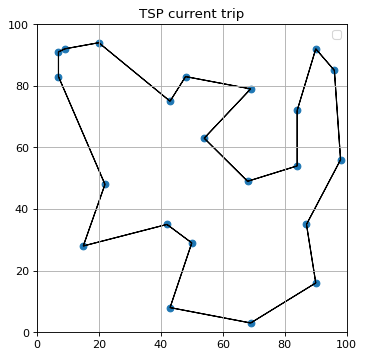

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


140	242   	470.929	91.922 	431.137	896.264


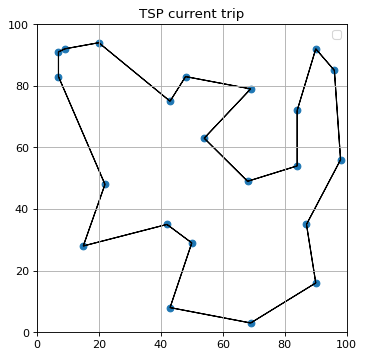

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


141	235   	472.143	105.453	431.137	1134.14


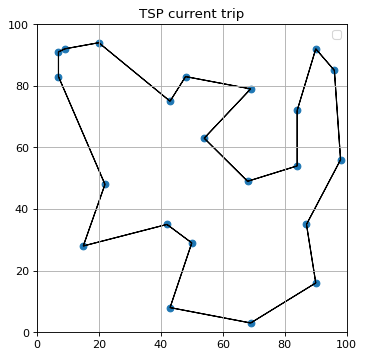

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


142	241   	484.267	112.187	431.137	1013.05


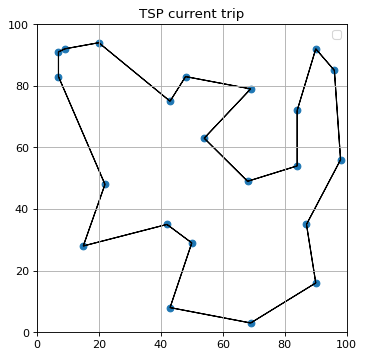

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


143	227   	477.83 	101.074	431.137	943.123


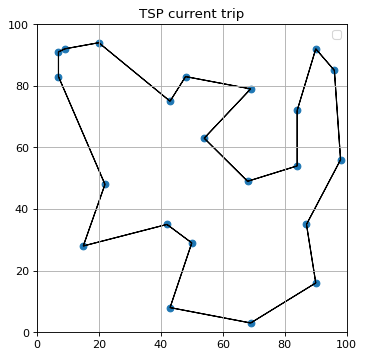

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


144	230   	492.71 	124.083	431.137	1033.86


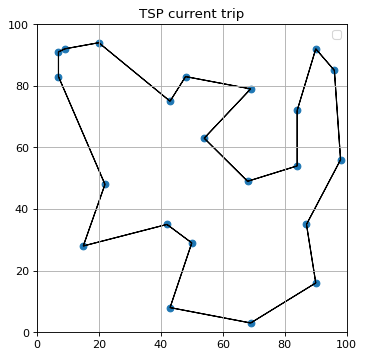

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


145	227   	471.51 	93.6125	431.137	920.33 


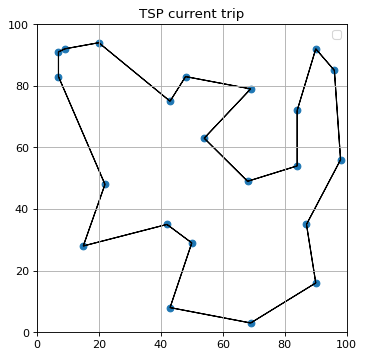

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


146	246   	477.456	105.755	431.137	1088.97


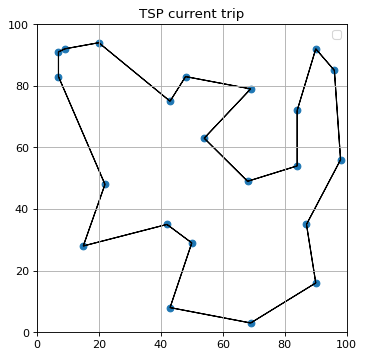

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


147	240   	475.804	100.206	431.137	1007.61


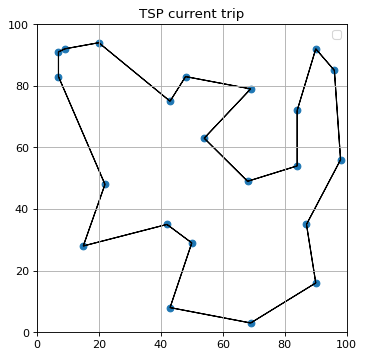

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


148	233   	469.396	100.65 	431.137	948.319


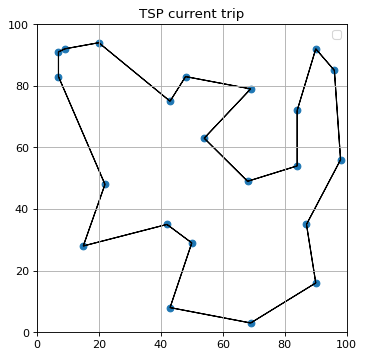

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


149	245   	486.275	113.409	431.137	1007.21


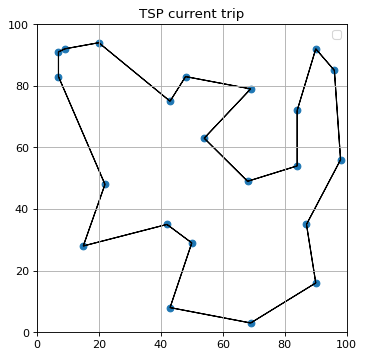

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


150	244   	466.605	89.162 	431.137	1001.59


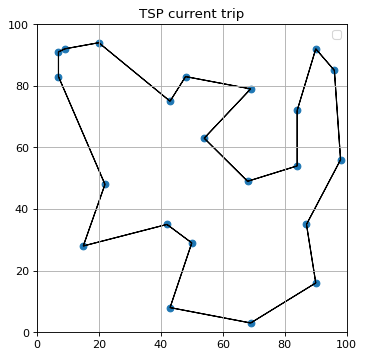

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


151	220   	478.863	109.945	431.137	1053.34


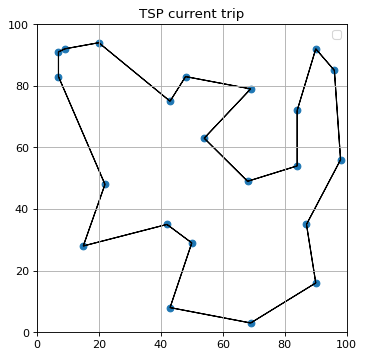

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


152	238   	478.041	103.221	431.137	981.15 


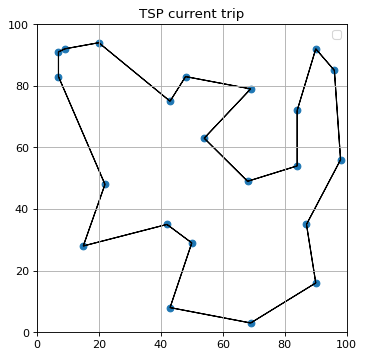

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


153	247   	484.132	124.142	431.137	1064.11


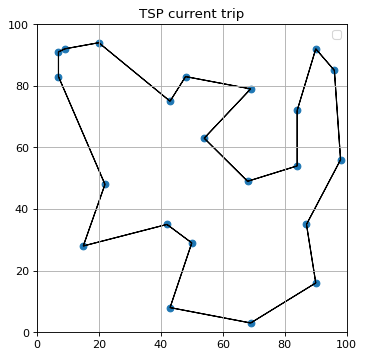

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


154	245   	479.261	102.044	431.137	981.125


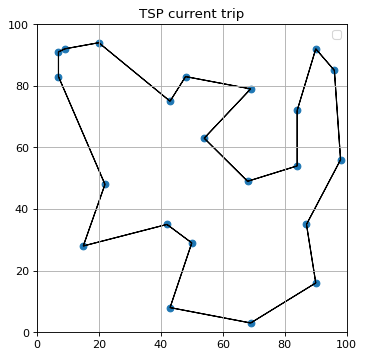

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


155	235   	472.58 	112.308	431.137	1107.62


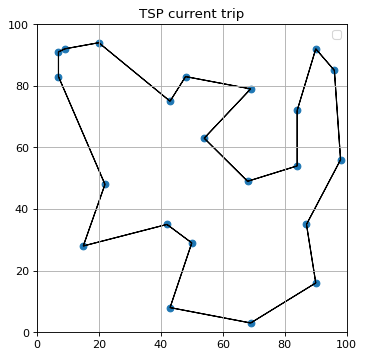

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


156	215   	467.918	97.3639	431.137	956.226


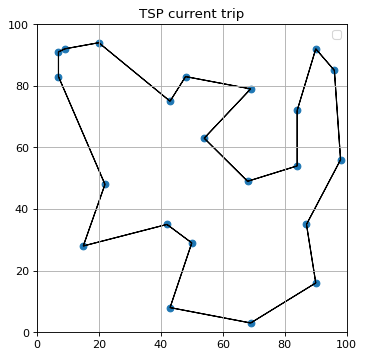

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


157	249   	474.079	110.882	431.137	1201.45


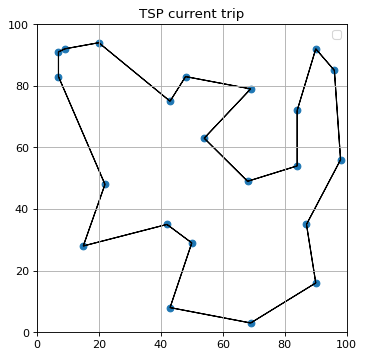

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


158	233   	470.997	106.78 	431.137	1163.45


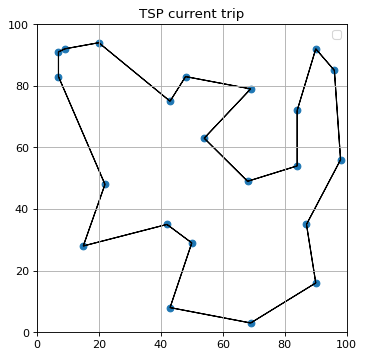

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


159	246   	474.518	106.014	431.137	1030.84


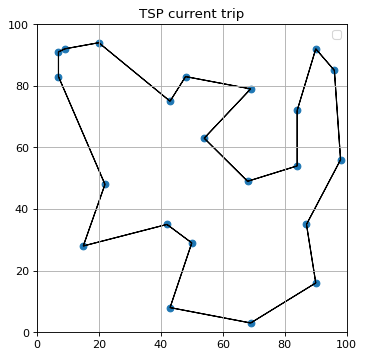

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


160	245   	485.219	114.293	431.137	1073.66


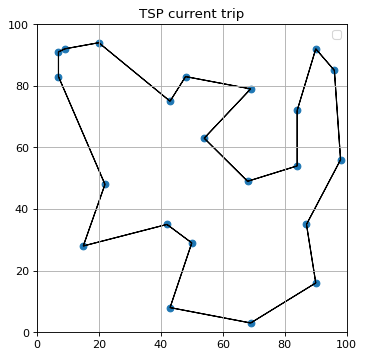

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


161	234   	468.043	90.695 	431.137	914.56 


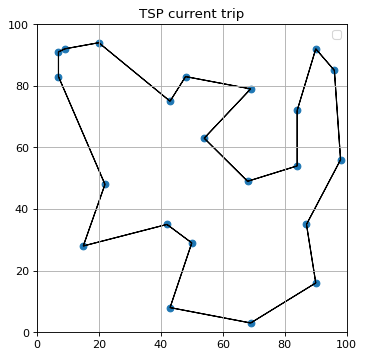

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


162	246   	483.274	110.085	431.137	1000.04


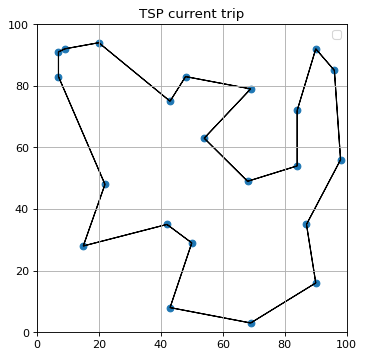

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


163	246   	474.704	100.815	431.137	1049.78


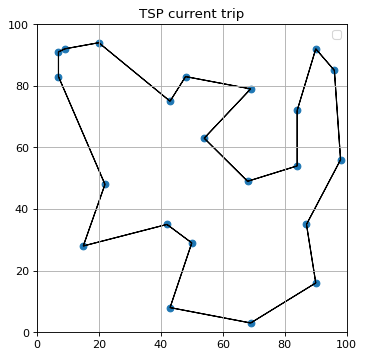

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


164	237   	470.558	96.6396	431.137	895.807


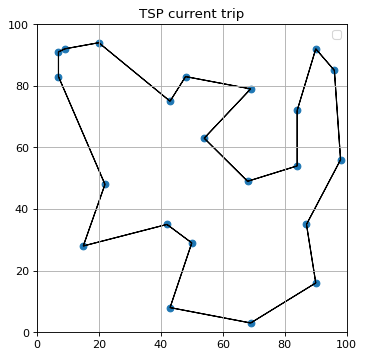

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


165	239   	475.542	104.261	431.137	1081.73


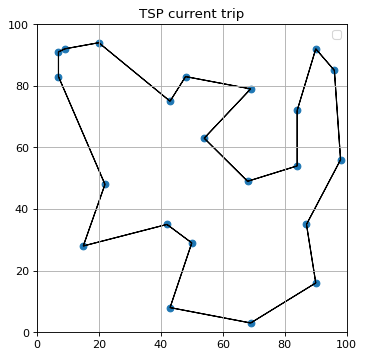

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


166	240   	472.906	102.103	431.137	935.807


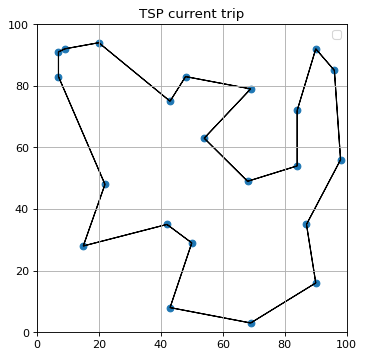

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


167	236   	475.779	104.41 	431.137	950.197


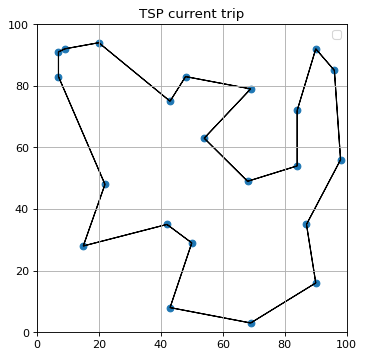

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


168	238   	481.214	109.535	431.137	918.292


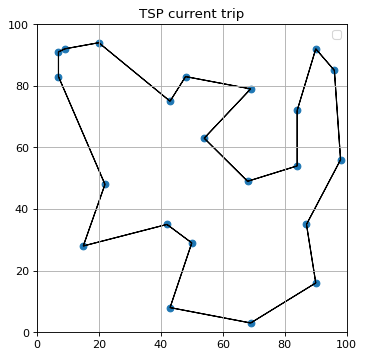

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


169	253   	476.316	102.854	431.137	1064.22


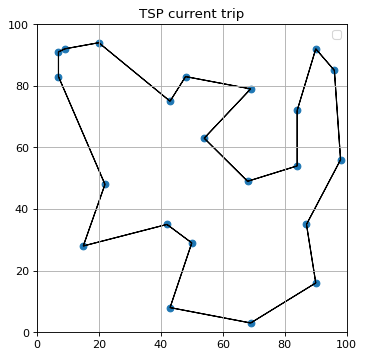

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


170	235   	465.068	86.7132	431.137	964.588


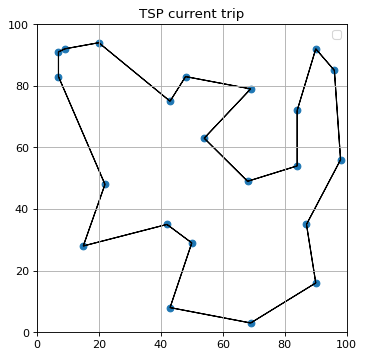

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


171	248   	474.589	104.129	431.137	1106.69


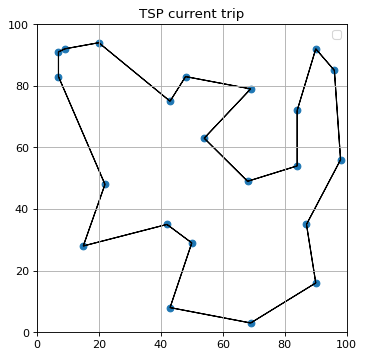

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


172	240   	463.748	91.103 	431.137	1033.97


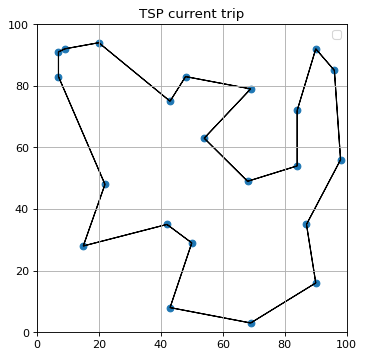

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


173	245   	468.773	94.8801	431.137	885.129


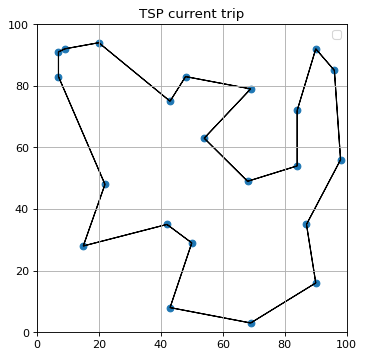

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


174	223   	479.643	116.085	431.137	1193.52


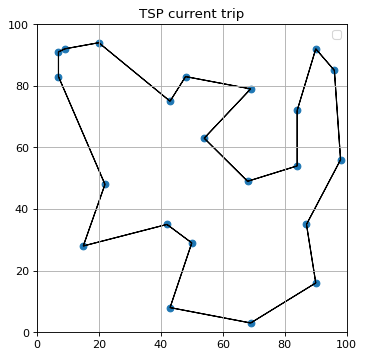

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


175	239   	478.288	117.724	431.137	1037.74


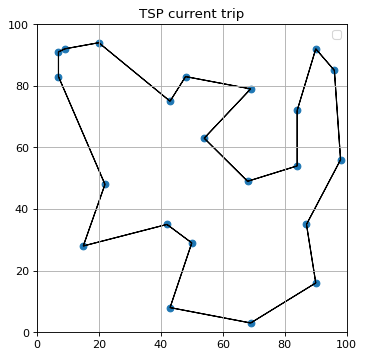

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


176	249   	478.731	120.135	431.137	1234.08


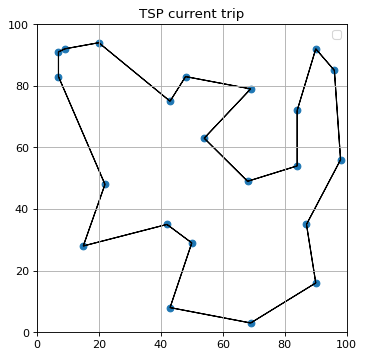

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


177	251   	482.141	112.073	431.137	954.608


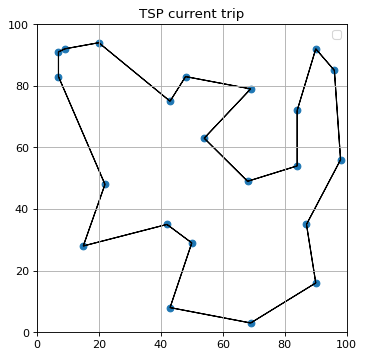

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


178	244   	489.048	121.909	431.137	1042.25


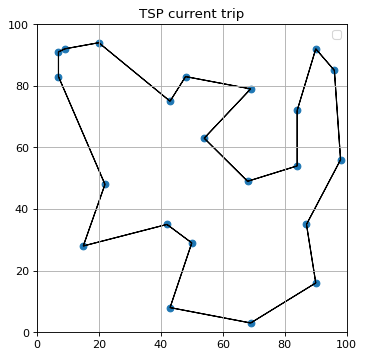

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


179	240   	480.788	109.818	431.137	1001.51


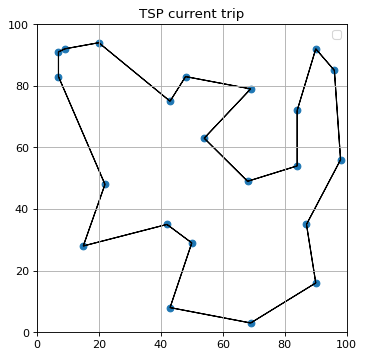

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


180	248   	469.567	95.9121	431.137	973.146


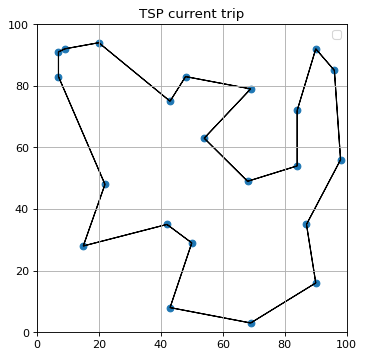

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


181	227   	471.833	105.422	431.137	1075.75


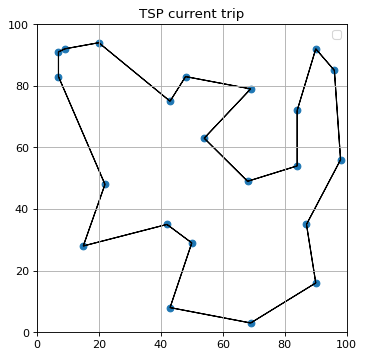

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


182	230   	481.717	111.765	431.137	1068.38


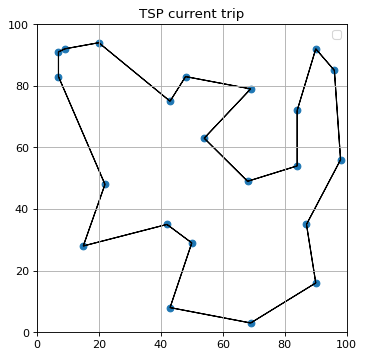

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


183	236   	485.379	120.493	431.137	1252.44


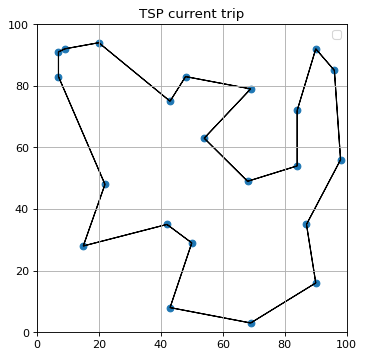

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


184	238   	479.641	115.466	431.137	1047.35


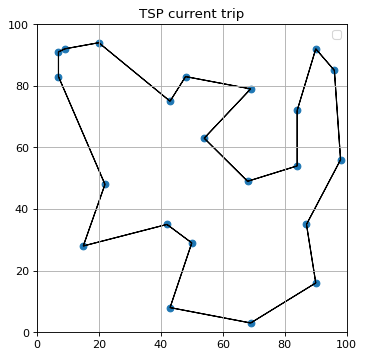

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


185	227   	469.111	93.0236	431.137	861.018


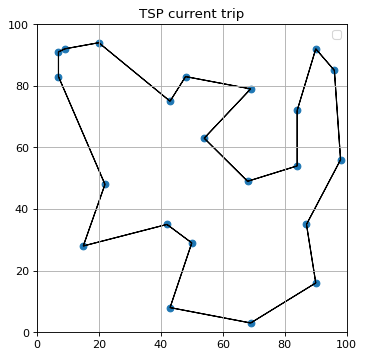

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


186	248   	475.246	110.102	431.137	1027.66


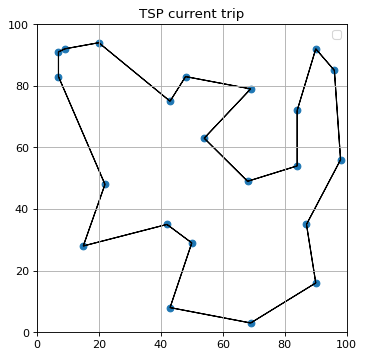

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


187	218   	488.164	126.535	431.137	1097.42


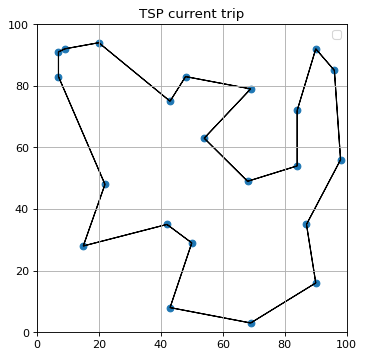

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


188	243   	481.16 	118.121	431.137	1110.02


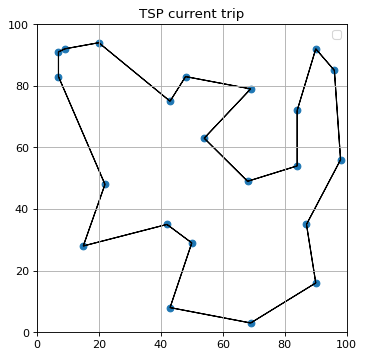

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


189	237   	480.084	114.085	431.137	1068.56


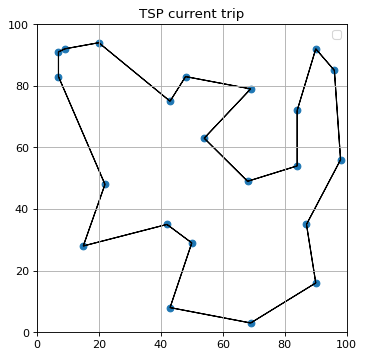

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


190	218   	468.471	102.507	431.137	1070.41


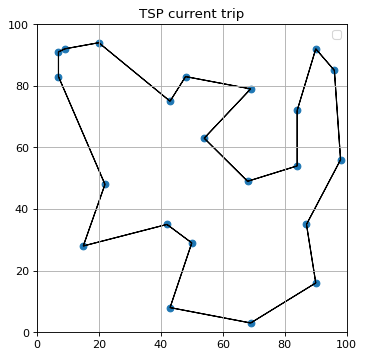

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


191	241   	470.428	99.0759	431.137	965.899


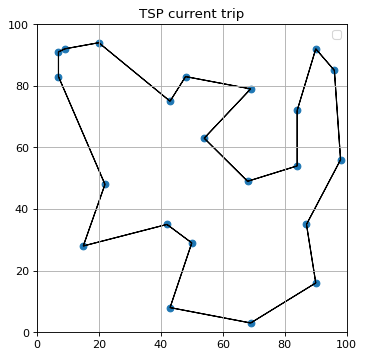

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


192	234   	482.556	109.969	431.137	959.736


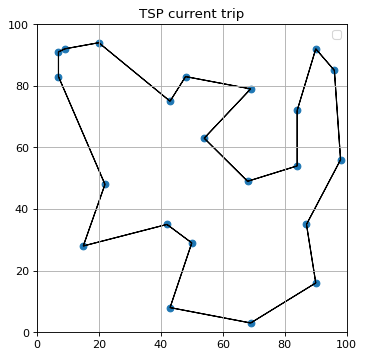

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


193	241   	477.803	113.965	431.137	1225.41


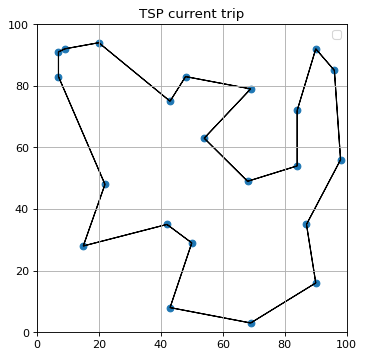

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


194	231   	468.093	85.368 	431.137	854.893


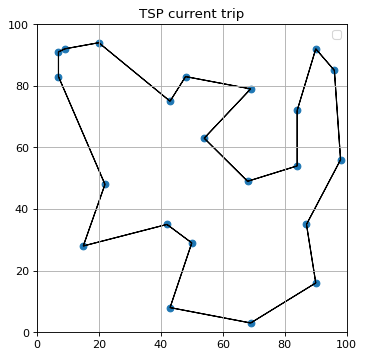

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


195	241   	470.493	99.9731	431.137	926.165


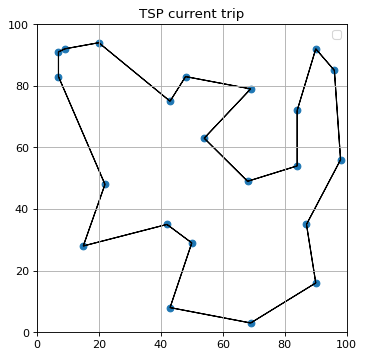

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


196	242   	478.584	107.597	431.137	1017.61


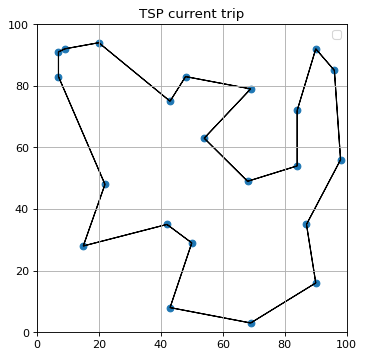

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


197	245   	474.227	97.6658	431.137	884.456


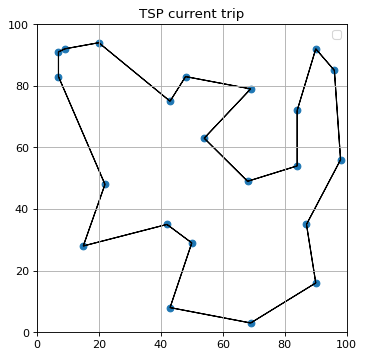

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


198	241   	474.414	105.505	431.137	1135.03


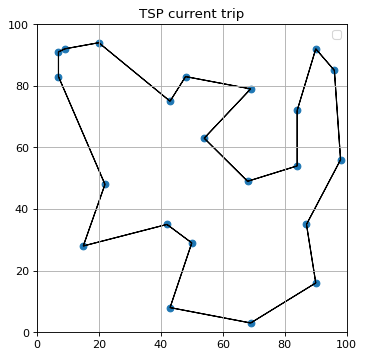

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


199	235   	478.753	112.712	431.137	987.112


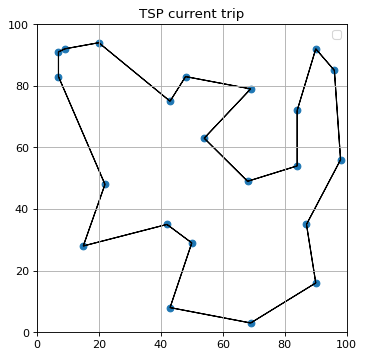

200	238   	461.192	84.4903	431.137	1040.09


In [25]:
## evolution
pop = toolbox.population(n=300)

hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

eaSimple(pop, toolbox, 0.7, 0.3, 200, stats=stats, halloffame=hof)